# Notebook to compare Model Results in Tolumne UCLA vs UA 

# Step 0 - Prepare Notebook

In [1]:
import os
import time 
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from snowML.datapipe.utils import data_utils as du
from snowML.LSTM import set_hyperparams as sh
from snowML.LSTM import LSTM_pre_process as pp 
from snowML.LSTM import LSTM_train as LSTM_tr
from snowML.LSTM import LSTM_metrics as met
from snowML.LSTM import LSTM_plot3 as plot3
from snowML.Scripts import local_training_mixed_loss as ml


# Step 1 - Define HyperParams and Test Hucs 

In [2]:
# get list of hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mar = data["maritime_hucs"]
print(f"Number of hcs_mar is {len(hucs_mar)}")


Number of hcs_mar is 154


In [3]:
# error ls 
error_ls = ['171100080201', '171100050602']


In [4]:
hucs_mar_clean = [huc for huc in hucs_mar if huc not in error_ls]
len(hucs_mar_clean)

152

In [5]:
# set hyperparams
# load base line params 
params = sh.create_hyper_dict()
# reset the ones we care about
params["learning_rate"] = .001
params["n_epochs"] = 10    
params["batch_size"] = 32
params["var_list"] = ['mean_pr', 'mean_tair']
params["expirement_name"] = "UA_UCLA_Compare"
params["loss_type"] = "mse"
params["train_size_dimension"] = "time"
params["train_size_fraction"] = .67
params["recursive_rredict"] = False 
params["UCLA"] = False # start w/ UA data then update 
#params

# Step 2 - Define model functions 

In [6]:
def pre_process(huc, params): 
    # normalize the data and create train/test split 
    df_dict = pp.pre_process_separate([huc], params["var_list"], UCLA = params["UCLA"], filter_dates=params["filter_dates"])
    train_size_frac = params["train_size_fraction"]
    df = df_dict[huc]
    df_train, _, _, _ = pp.train_test_split_time(df, train_size_frac)
    return df_dict, df_train

def train_model (df_train, params): 
    model_dawgs, optimizer_dawgs, loss_fn_dawgs = ml.initialize_model(params)
   
    for epoch in range(params["n_epochs"]):
        # for local training, call fine_tune instead of pre_train
        #print(f"Training in epoch {epoch}")
        LSTM_tr.fine_tune(
            model_dawgs,
            optimizer_dawgs,
            loss_fn_dawgs,
            df_train,
            params,
            epoch
            )
    return model_dawgs 

def evaluate(model_dawgs_trained, df_dict, huc, params):
    if params["UCLA"]:
        suffix = "UCLA"
    else: 
        suffix = "UA"
    data, y_tr_pred, y_te_pred, y_tr_true, y_te_true,  y_te_pred_recur, train_size, = LSTM_tr.predict_prep (model_dawgs_trained,
                df_dict, huc, params)
    metric_dict_test = met.calc_metrics(y_te_true, y_te_pred, metric_type = f"test_{suffix}")
    if y_te_pred_recur is not None:
        metric_dict_test_recur = met.calc_metrics(y_te_true, y_te_pred_recur, metric_type = f"test_recur_{suffix}")
        combined_dict = {**metric_dict_test, **metric_dict_test_recur}
    else:
        combined_dict = metric_dict_test
        
    return combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size


def combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size, params):
    results_df = data[["mean_swe"]].copy()
    results_df["y_tr_pred"] = list(y_tr_pred) + [float('nan')] * (len(results_df) - len(y_tr_pred))
    results_df["y_te_pred"] = [float('nan')] * (train_size+params["lookback"]) + list(y_te_pred)
    results_df["y_tr_true"] = list(y_tr_true) + [float('nan')] * (len(results_df) - len(y_tr_true))
    results_df["y_te_true"] = [float('nan')] *(train_size+params["lookback"]) + list(y_te_true)
    return results_df

def label_results(df, suffix):
    df = df.add_suffix(f"_{suffix}")
    return df

def run_one_data_type (huc, params, data_type = "UA"): 
    if data_type == "UCLA": 
        params["UCLA"] = True 
        suffix = "UCLA" 
    else: 
        params["UCLA"] = False
        suffix = "UA"
    df_dict, df_train = pre_process(huc, params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # ignore warning about drop param being irrelevant with single deep layer
        model_dawgs_trained = train_model(df_train, params)
    combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size = evaluate(model_dawgs_trained, df_dict, huc, params)
    df_results = combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size, params)
    df_results = label_results(df_results, suffix)
    return combined_dict, df_results, tr_size

def run_all(hucs, params, dis = False): 
    #time_start = time.time()
    dict_UA, results_df_UA, tr_size_UA  = run_one_data_type(huc, params)
    dict_UCLA, results_df_UCLA, tr_size_UCLA = run_one_data_type (huc, params, data_type = "UCLA")
    metrics_dict_all = {**dict_UA, **dict_UCLA}
    results_df_all = pd.concat([results_df_UA, results_df_UCLA], axis=1)
    plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size_UA, huc, params, dis = dis)
    #du.elapsed(time_start)
    return metrics_dict_all, results_df_all
       

def plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size, huc, params, dis = False):
    cutoff = tr_size + params["lookback"]
    df_plot = results_df_all.iloc[cutoff:]

    # Prepare data for plots
    plot_dict_UA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UA"], "blue", "SWE Estimates UA Data (Physics Based Model)", n_offset=0)
    plot_dict_UA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UA"], "green", "SWE Predictions UA Data", n_offset=0)

    plot_dict_UCLA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UCLA"], "black", "SWE Estimates UCLA Data (Physics Based Model)", n_offset=0)
    plot_dict_UCLA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UCLA"], "red", "SWE Predictions UCLA Data", n_offset=0)

    x_axis_vals = df_plot.index
    ttl = f"SWE_Actual_vs_Predicted_for_huc_{huc}"

    # Temp file paths
    filenames = [f"plot_{i}.png" for i in range(3)]

    # Plot and save each figure
    plot3.plot3b(x_axis_vals, [plot_dict_UA_true, plot_dict_UA_pred], ttl + "_UA_data", metrics_dict=dict_UA)
    plt.savefig(filenames[0])
    plt.close()

    plot3.plot3b(x_axis_vals, [plot_dict_UCLA_true, plot_dict_UCLA_pred], ttl + "_UCLA_data", metrics_dict=dict_UCLA)
    plt.savefig(filenames[1])
    plt.close()

    plot3.plot3b(x_axis_vals,
                 [plot_dict_UA_true, plot_dict_UA_pred, plot_dict_UCLA_true, plot_dict_UCLA_pred],
                 ttl, metrics_dict=metrics_dict_all)
    plt.savefig(filenames[2])
    plt.close()

    # Combine saved plots vertically
    images = [Image.open(fname) for fname in filenames]
    widths, heights = zip(*(img.size for img in images))

    total_height = sum(heights)
    max_width = max(widths)
    combined_img = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the final combined image
    output_path = f"charts/SWE_combined_plots_{huc}.png"
    combined_img.save(output_path)
    if dis: 
        display(combined_img)
    
    # Cleanup temporary files
    for fname in filenames:
        os.remove(fname)

    print(f"Saved combined plot to {output_path}")


# Step 3 - Get Results Sample Huc 

In [7]:
huc = 171100050604

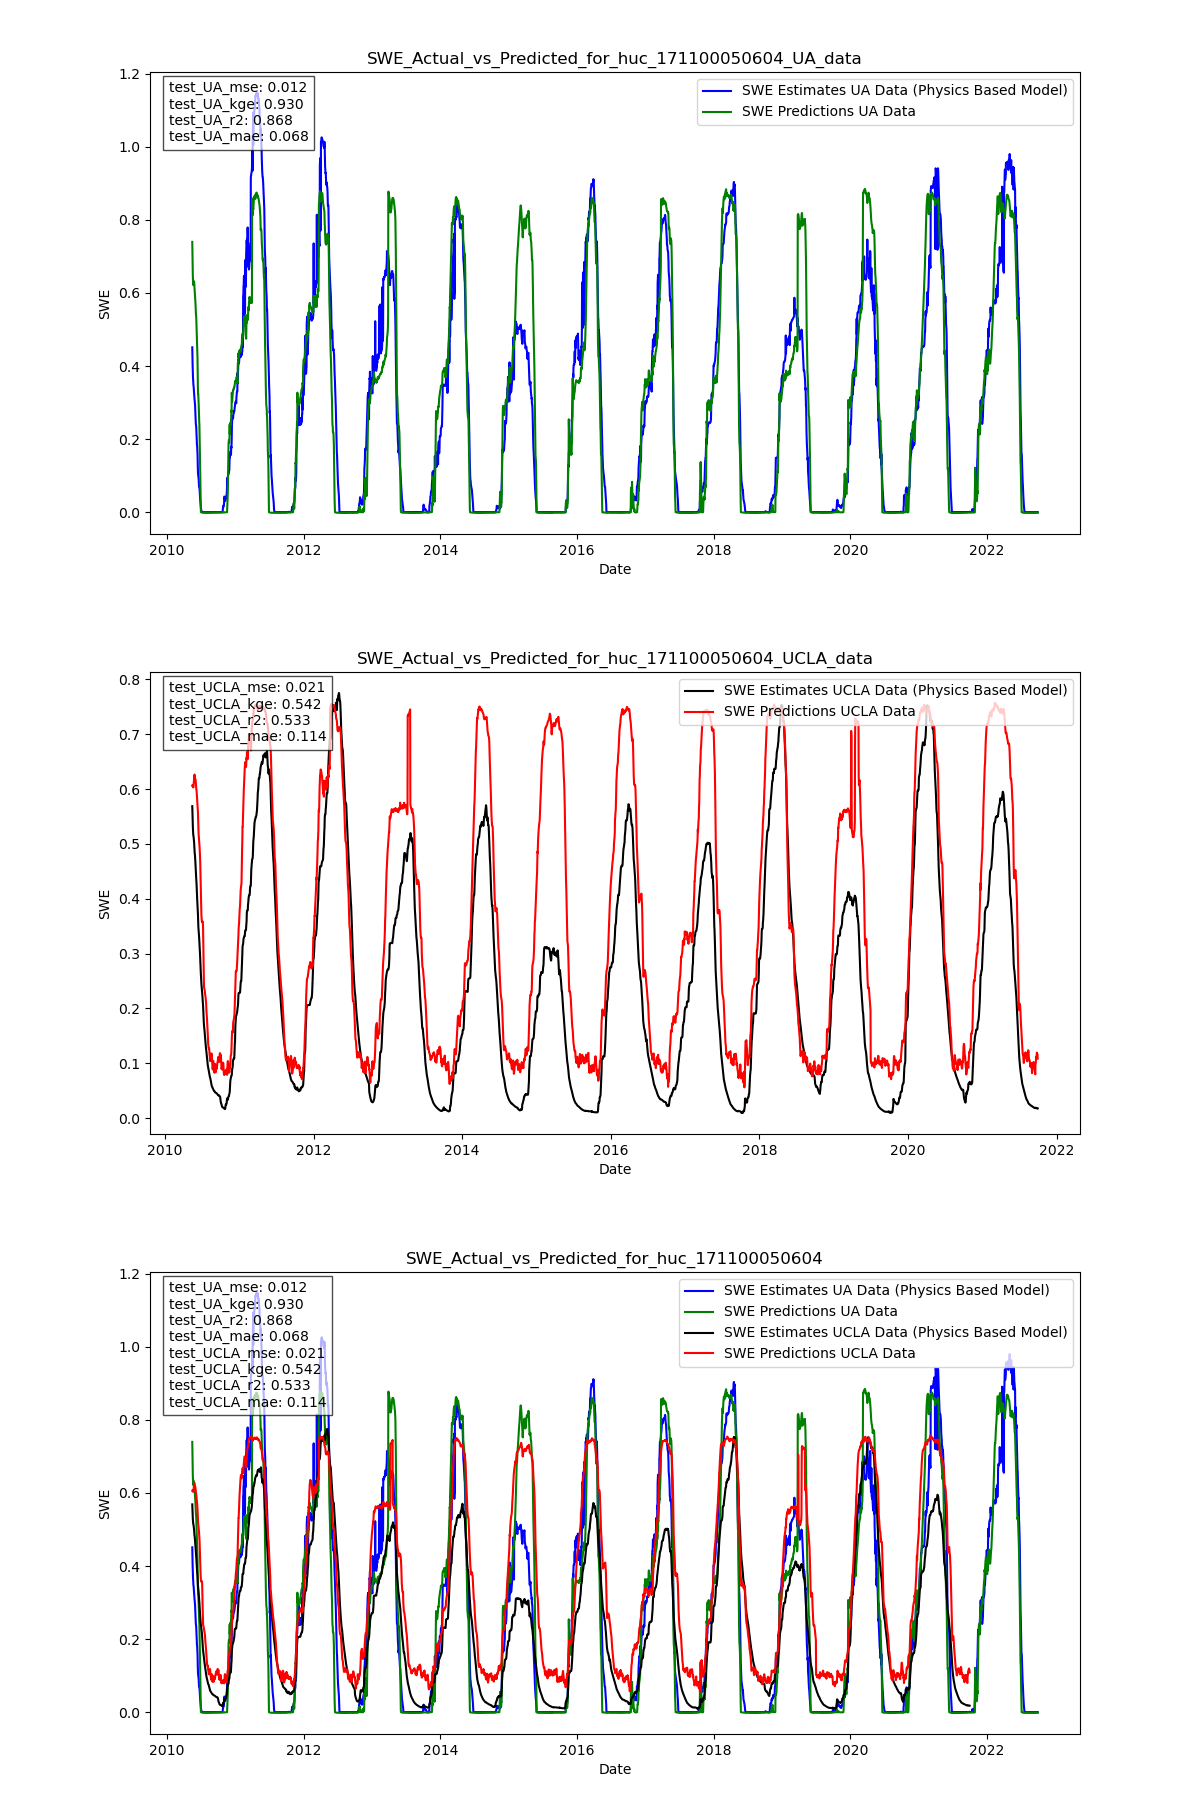

Saved combined plot to charts/SWE_combined_plots_171100050604.png


In [8]:
dict, df = run_all(huc, params, dis = True)

In [9]:
df

,mean_swe_UA,y_tr_pred_UA,y_te_pred_UA,y_tr_true_UA,y_te_true_UA,mean_swe_UCLA,y_tr_pred_UCLA,y_te_pred_UCLA,y_tr_true_UCLA,y_te_true_UCLA
day,,,,,,,,,,
1983-10-01,0.0,[0.8509677],NaN,[0.64025],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-02,0.0,[0.85279536],NaN,[0.639],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-03,0.0,[0.8548615],NaN,[0.63475],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-04,0.0,[0.85435563],NaN,[0.63425],NaN,NaN,NaN,NaN,NaN,NaN
1983-10-05,0.0,[0.8543907],NaN,[0.63325],NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-25,0.0,NaN,[-0.001776815],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2022-09-26,0.0,NaN,[-0.0018891981],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2022-09-27,0.0,NaN,[-0.0019553727],NaN,[0.0],NaN,NaN,NaN,NaN,NaN


# Step 4 Loop through all the maritime hucs

In [10]:
df_results = None
count = 0

for huc in hucs_mar_clean:    
    count += 1
    print(f"processing huc {count}")
    dict, df = run_all(huc, params)
    f_out = f"model_results_UA_UCLA_huc_{huc}"
    b = "snowml-results"
    du.dat_to_s3(df, b, f_out, file_type="csv")
    new_row = pd.DataFrame([dict])
    new_row["huc"] = huc
    
    if df_results is None:
        df_results = new_row
    else:
        df_results = pd.concat([df_results, new_row], ignore_index=True)

df_results.set_index("huc", inplace=True)
f_out = "metrics_UA_v_UCLA_maritime"
du.dat_to_s3(df_results, b, f_out, file_type="csv")
df_results


processing huc 1
Saved combined plot to charts/SWE_combined_plots_170200090101.png
File model_results_UA_UCLA_huc_170200090101.csv successfully uploaded to snowml-results
processing huc 2
Saved combined plot to charts/SWE_combined_plots_170200090102.png
File model_results_UA_UCLA_huc_170200090102.csv successfully uploaded to snowml-results
processing huc 3
Saved combined plot to charts/SWE_combined_plots_170200090103.png
File model_results_UA_UCLA_huc_170200090103.csv successfully uploaded to snowml-results
processing huc 4
Saved combined plot to charts/SWE_combined_plots_170200090104.png
File model_results_UA_UCLA_huc_170200090104.csv successfully uploaded to snowml-results
processing huc 5
Saved combined plot to charts/SWE_combined_plots_170200090105.png
File model_results_UA_UCLA_huc_170200090105.csv successfully uploaded to snowml-results
processing huc 6
Saved combined plot to charts/SWE_combined_plots_170200090106.png
File model_results_UA_UCLA_huc_170200090106.csv successfully u

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
huc,,,,,,,,
170200090101,0.012592,0.917876,0.928107,0.072538,0.017589,0.783405,0.740938,0.095948
170200090102,0.014717,0.829868,0.910904,0.080353,0.008927,0.927410,0.883996,0.064525
170200090103,0.013027,0.832228,0.899787,0.064935,0.013667,0.692916,0.764067,0.094716
170200090104,0.010109,0.939195,0.944063,0.062362,0.014501,0.772411,0.857216,0.095563
170200090105,0.017270,0.942162,0.927647,0.090644,0.014729,0.818288,0.870133,0.101248
...,...,...,...,...,...,...,...,...
170200100202,0.008725,0.906995,0.921914,0.059186,0.013293,0.434122,0.466674,0.079561
170200100203,0.021433,0.789526,0.809405,0.095343,0.005833,0.907075,0.846305,0.052487
171100070101,0.009637,0.782100,0.713666,0.051486,0.020235,0.469151,0.492011,0.096974


In [11]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.020708,0.775770,0.812947,0.079052,0.037952,0.504362,0.318614,0.120451
std,0.022745,0.149096,0.121720,0.039993,0.124115,0.259405,1.503938,0.115992
min,0.000490,0.250770,0.355548,0.010322,0.001083,-0.497983,-16.118697,0.020225
25%,0.008945,0.701487,0.748985,0.053834,0.009435,0.390595,0.375834,0.070112
50%,0.015010,0.819578,0.852007,0.074841,0.019281,0.531416,0.584085,0.100910
75%,0.023891,0.887745,0.904787,0.096635,0.032995,0.681550,0.735462,0.143117
max,0.161606,0.965967,0.960177,0.252552,1.403166,0.945633,0.912525,1.164736


In [12]:
df_results["kge_diff"] = df_results["test_UA_kge"] - df_results["test_UCLA_kge"]
df_results

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200090101,0.012592,0.917876,0.928107,0.072538,0.017589,0.783405,0.740938,0.095948,0.134471
170200090102,0.014717,0.829868,0.910904,0.080353,0.008927,0.927410,0.883996,0.064525,-0.097542
170200090103,0.013027,0.832228,0.899787,0.064935,0.013667,0.692916,0.764067,0.094716,0.139312
170200090104,0.010109,0.939195,0.944063,0.062362,0.014501,0.772411,0.857216,0.095563,0.166784
170200090105,0.017270,0.942162,0.927647,0.090644,0.014729,0.818288,0.870133,0.101248,0.123873
...,...,...,...,...,...,...,...,...,...
170200100202,0.008725,0.906995,0.921914,0.059186,0.013293,0.434122,0.466674,0.079561,0.472874
170200100203,0.021433,0.789526,0.809405,0.095343,0.005833,0.907075,0.846305,0.052487,-0.117549
171100070101,0.009637,0.782100,0.713666,0.051486,0.020235,0.469151,0.492011,0.096974,0.312949


In [13]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.020708,0.775770,0.812947,0.079052,0.037952,0.504362,0.318614,0.120451,0.271408
std,0.022745,0.149096,0.121720,0.039993,0.124115,0.259405,1.503938,0.115992,0.291631
min,0.000490,0.250770,0.355548,0.010322,0.001083,-0.497983,-16.118697,0.020225,-0.586480
25%,0.008945,0.701487,0.748985,0.053834,0.009435,0.390595,0.375834,0.070112,0.082516
50%,0.015010,0.819578,0.852007,0.074841,0.019281,0.531416,0.584085,0.100910,0.274442
75%,0.023891,0.887745,0.904787,0.096635,0.032995,0.681550,0.735462,0.143117,0.425035
max,0.161606,0.965967,0.960177,0.252552,1.403166,0.945633,0.912525,1.164736,1.349146


In [14]:
df_sorted = df_results.sort_values(by="kge_diff", ascending=False)
df_sorted

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200110307,0.003865,0.851163,0.870712,0.029468,0.015713,-0.497983,-1.181828,0.074964,1.349146
170200110305,0.005023,0.901662,0.894571,0.035874,0.024199,-0.259647,-0.713726,0.098109,1.161309
170200110105,0.006706,0.742676,0.823319,0.040257,0.016377,-0.346842,-0.786386,0.089617,1.089518
171100080107,0.020095,0.832951,0.687956,0.078404,0.045938,-0.177073,-0.355838,0.146295,1.010024
170200110110,0.005465,0.881635,0.836586,0.035887,0.015648,-0.015916,-0.251970,0.090805,0.897551
...,...,...,...,...,...,...,...,...,...
170300010101,0.053094,0.511227,0.634649,0.123876,0.011785,0.750643,0.840133,0.069923,-0.239417
171100051002,0.092258,0.380963,0.522183,0.204700,0.149317,0.671235,-0.000171,0.344166,-0.290272
171100050904,0.039278,0.499288,0.636991,0.122929,0.008874,0.896898,0.879186,0.073479,-0.397609


In [15]:
# with mlflow.start_run():
        #ml.set_ml_server(params)
        # log all the params
        #mlflow.log_params(params)
        # log the hucs & train size fraction
        #mlflow.log_param("hucs", hucs)
        # log the model
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}", pickle_module=cloudpickle)
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}")
            